<a href="https://colab.research.google.com/github/noorfatima640/water-quality-ml/blob/main/XGBoost_and_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('/content/water-quality-FINAL-cleaned.csv')
df.columns = df.columns.str.strip()

In [ ]:
def score_do(val):
    return np.clip(20*val + 50, 0, 100)

def score_ph(val):
    ideal = 7.5
    return np.clip(100 - abs(val - ideal)*20, 0, 100)

def score_temp(t):
    return np.clip(100 - (t-20)*4, 0, 100)

def inverse_score(val, scale=50):
    return np.clip(100 - max(0, val*scale), 0, 100)

df["DO_score"]       = df["DO"].apply(score_do)
df["pH_score"]       = df["pH"].apply(score_ph)
df["Temp_score"]     = df["Temperature"].apply(score_temp)
df["TotalN_score"]   = df["Total_N"].apply(lambda x: inverse_score(x, scale=60))
df["Cond_score"]     = df["Conductivity"].apply(lambda x: inverse_score(x, scale=40))
df["OrthoP_score"]   = df["Orthophosphate"].apply(lambda x: inverse_score(x, scale=120))

weights = {
    "DO_score": 0.23,
    "pH_score": 0.23,
    "Temp_score": 0.18,
    "TotalN_score": 0.13,
    "Cond_score": 0.13,
    "OrthoP_score": 0.10,
}

df["WQI"] = (
    df["DO_score"] * weights["DO_score"] +
    df["pH_score"] * weights["pH_score"] +
    df["Temp_score"] * weights["Temp_score"] +
    df["TotalN_score"] * weights["TotalN_score"] +
    df["Cond_score"] * weights["Cond_score"] +
    df["OrthoP_score"] * weights["OrthoP_score"]
)

df.to_csv("cleaned_WQI_Score_Data.csv", index=False)

In [ ]:
df = pd.get_dummies(df, columns=["Season"], drop_first=True)

In [ ]:
chemicals = [
    "pH","DO","Conductivity","Temperature",
    "Total_N","Orthophosphate"
]

X_wqi = df[chemicals]
y_wqi = df["WQI"]

In [ ]:
temp_features = [
    "pH","DO","Conductivity","Total_N","Orthophosphate",
    "WQI","Year","Month","Season_numerical",
    "Season_Spring","Season_Summer","Season_Winter"
]

X_temp = df[temp_features]
y_temp = df["Temperature"]

In [ ]:
from sklearn.model_selection import train_test_split

X_train_wqi, X_test_wqi, y_train_wqi, y_test_wqi = train_test_split(
    X_wqi, y_wqi, test_size=0.2, random_state=42
)

X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

model_temp_xgb = XGBRegressor(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model_temp_xgb.fit(X_train_temp, y_train_temp)

pred_temp = model_temp_xgb.predict(X_test_temp)

rmse_temp = np.sqrt(mean_squared_error(y_test_temp, pred_temp))
r2_temp = r2_score(y_test_temp, pred_temp)

print("Temperature RMSE:", rmse_temp)
print("Temperature R² :", r2_temp)

Temperature RMSE: 0.2604742882577315
Temperature R² : 0.8701039054193389


In [ ]:
model_wqi_xgb = XGBRegressor(
    n_estimators=150,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)

model_wqi_xgb.fit(X_train_wqi, y_train_wqi)

pred_wqi = model_wqi_xgb.predict(X_test_wqi)

rmse_wqi = np.sqrt(mean_squared_error(y_test_wqi, pred_wqi))
r2_wqi = r2_score(y_test_wqi, pred_wqi)

print("WQI RMSE:", rmse_wqi)
print("WQI R² :", r2_wqi)

WQI RMSE: 0.22275795811938096
WQI R² : 0.9980110946588024


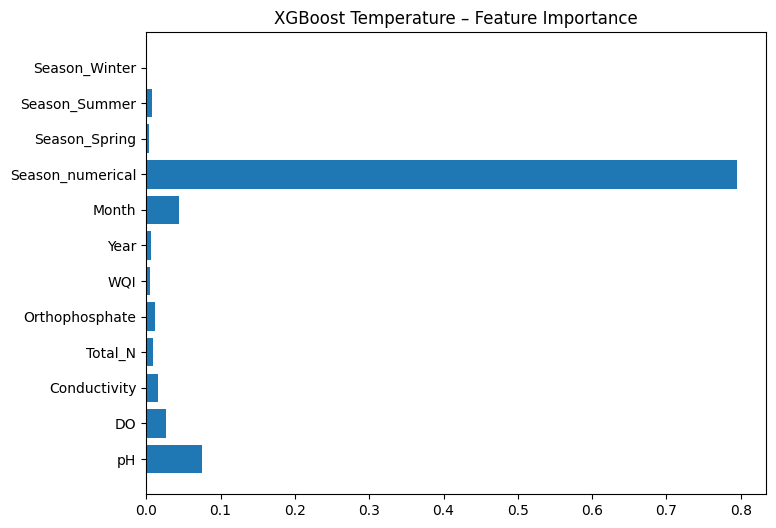

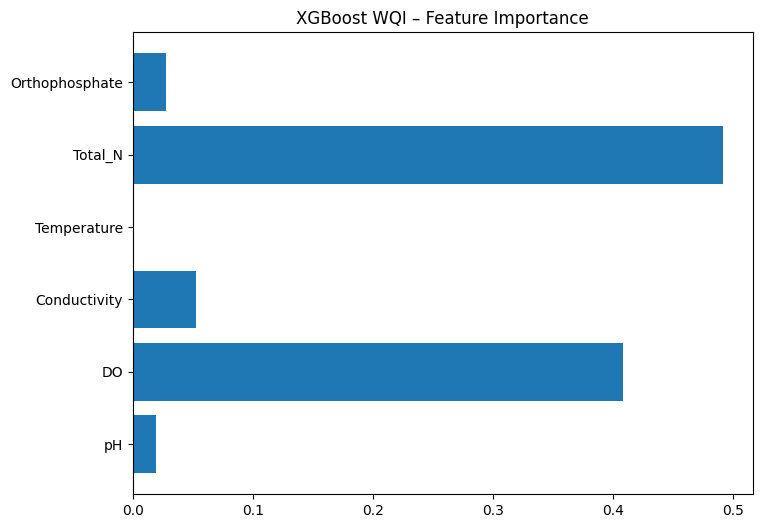

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.barh(X_temp.columns, model_temp_xgb.feature_importances_)
plt.title("XGBoost Temperature – Feature Importance")
plt.show()

plt.figure(figsize=(8,6))
plt.barh(X_wqi.columns, model_wqi_xgb.feature_importances_)
plt.title("XGBoost WQI – Feature Importance")
plt.show()



In [ ]:
!pip install shap

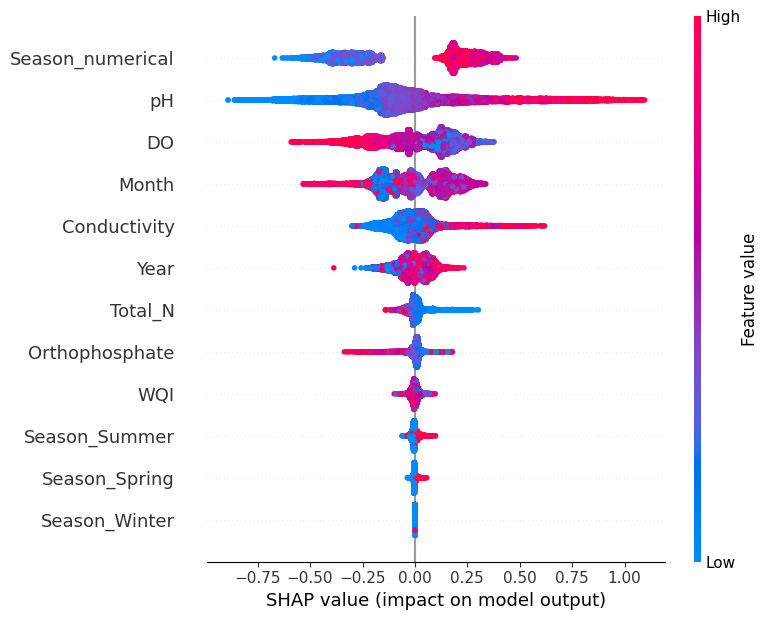

In [ ]:
import shap
explainer_temp = shap.TreeExplainer(model_temp_xgb)
shap_values_temp = explainer_temp.shap_values(X_test_temp)

shap.summary_plot(shap_values_temp, X_test_temp)

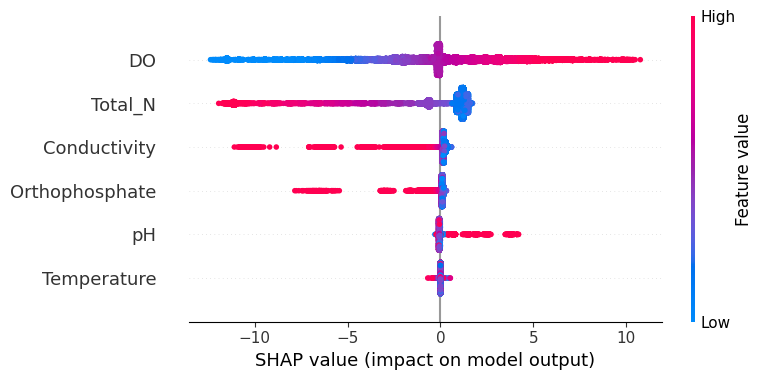

In [ ]:
explainer_wqi = shap.TreeExplainer(model_wqi_xgb)
shap_values_wqi = explainer_wqi.shap_values(X_test_wqi)

shap.summary_plot(shap_values_wqi, X_test_wqi)

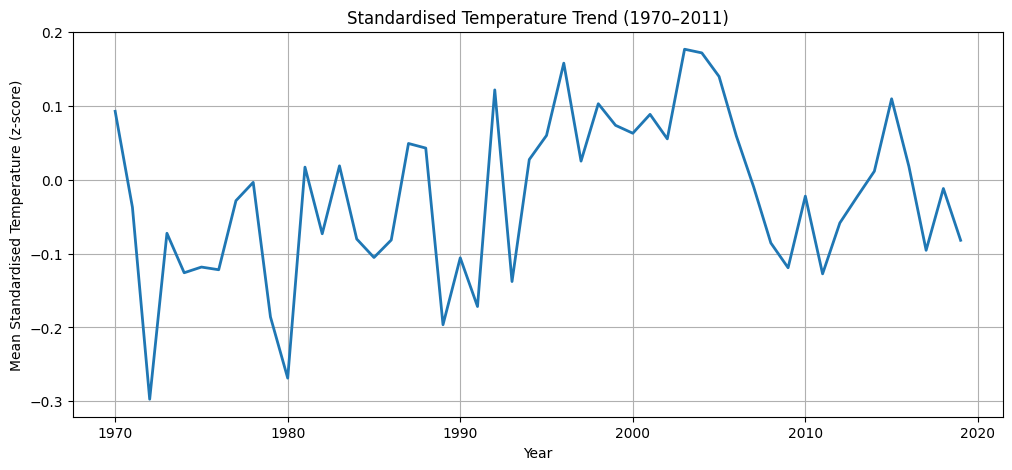

In [ ]:
# LONG-TERM TEMPERATURE TREND (STANDARDISED)
df_year = df.groupby("Year")["Temperature"].mean().reset_index()

plt.figure(figsize=(12,5))
plt.plot(df_year["Year"], df_year["Temperature"], linewidth=2)
plt.title("Standardised Temperature Trend (1970–2011)")
plt.xlabel("Year")
plt.ylabel("Mean Standardised Temperature (z-score)")
plt.grid(True)
plt.show()

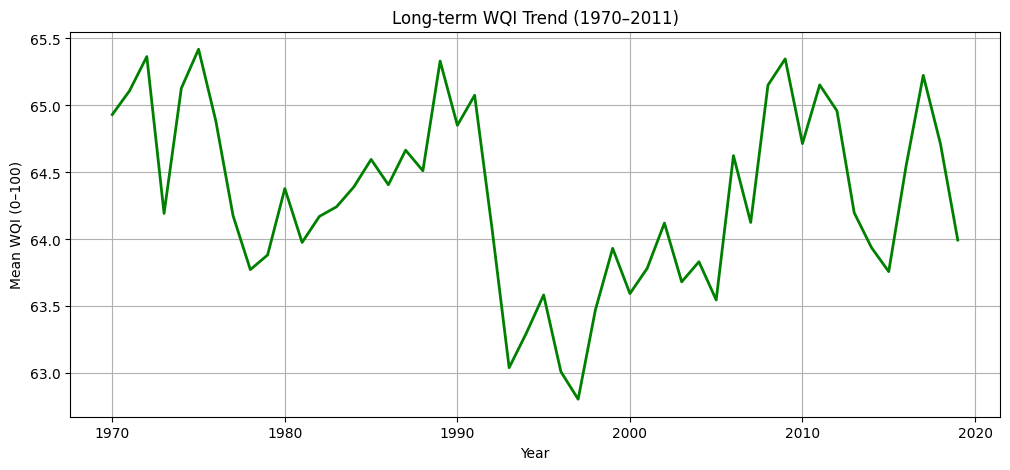

In [ ]:
df_year = df.groupby("Year")["WQI"].mean().reset_index()

plt.figure(figsize=(12,5))
plt.plot(df_year["Year"], df_year["WQI"], linewidth=2, color="green")
plt.title("Long-term WQI Trend (1970–2011)")
plt.xlabel("Year")
plt.ylabel("Mean WQI (0–100)")
plt.grid(True)
plt.show()

In [ ]:
df[["Temperature", "WQI"]].corr()

,Temperature,WQI
Temperature,1.000000,-0.126737
WQI,-0.126737,1.000000


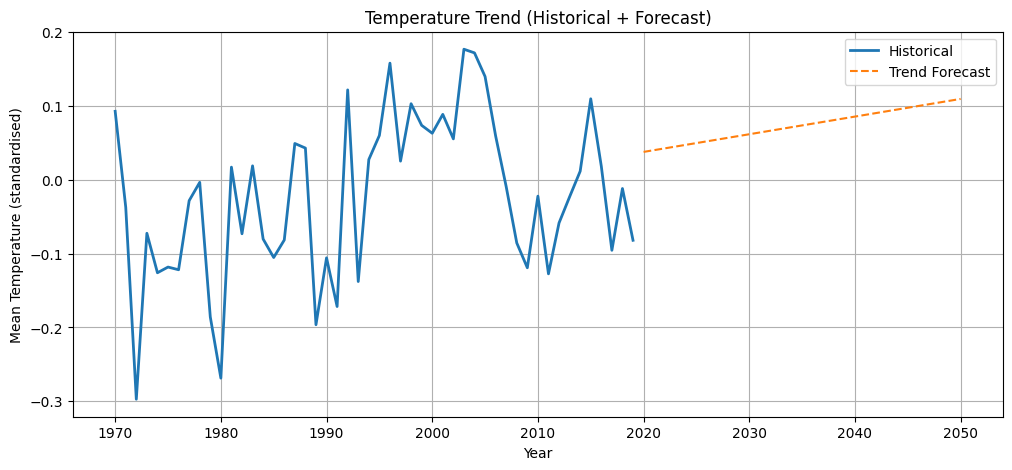

,Temperature,WQI
Temperature,1.000000,-0.126737
WQI,-0.126737,1.000000


In [ ]:
from sklearn.linear_model import LinearRegression

# 1. Yearly averages for Temperature and WQI
df_year = df.groupby("Year")[["Temperature", "WQI"]].mean().reset_index()

# 2. Fit a linear model for long-term Temperature trend
model = LinearRegression()
model.fit(df_year[["Year"]], df_year["Temperature"])

# 3. Create future years up to 2050
future_years = pd.DataFrame({"Year": np.arange(df_year["Year"].max() + 1, 2051)})
future_years["Temp_Forecast"] = model.predict(future_years[["Year"]])

# 4. Plot historical vs trend to 2050
plt.figure(figsize=(12,5))
plt.plot(df_year["Year"], df_year["Temperature"], linewidth=2, label="Historical")
plt.plot(future_years["Year"], future_years["Temp_Forecast"], "--", label="Trend Forecast")
plt.title("Temperature Trend (Historical + Forecast)")
plt.xlabel("Year")
plt.ylabel("Mean Temperature (standardised)")
plt.grid(True)
plt.legend()
plt.show()

# 5. Correlation between Temperature and WQI
df[["Temperature", "WQI"]].corr()
